---
# **Verificación experimental de la ley de Malus usando un ESP32 controlado con MicroPython**
---
Andrés Felipe Riaño Quintanilla     1083928808

Santiago Julio Dávila               1000413445

---
Laboratorio Avanzado I, Instituto de Física, Universidad de Antioquia

## **Introducción**

Considérese una onda electromagnética $\vec{E}=\vec{E}_0\cos(\vec{k}\cdot\vec{r}-\omega t)$, $\vec{B}=\vec{B}_0\cos(\vec{k}\cdot\vec{r}-\omega t)$, con $B_0=cE_0$. El vector de Poynting de dicha onda es dado por $\vec{S}=c^2\epsilon_0\vec{E}\times\vec{B}$. Defínase la _irradiancia_ o _intensidad_ como el promedio de la magnitud del vector de Poynting: $I=\langle S \rangle$. Se puede verificar que

$$
I=\dfrac{c\epsilon_0}{2}E_0^2.
$$


<img src="https://raw.githubusercontent.com/SantiagoJulioD/LabAv1/refs/heads/main/LabAv1-P3/graficas-1.png" alt="drawing" width="600"/>

Fig. 1. Esquema del sistema para deducir la ley de Malus.


A continuación, para el análisis del sistema con el polarizador, se adoptará la notación de Dirac para los vectores, pues facilita la explicación operativa de la acción del polarizador en el sistema. Considérese una onda polarizada linealmente: 

$$|E_{in}\rangle=E_0\cos\alpha |H\rangle+E_0\sin\alpha |V\rangle,$$

donde $|H\rangle$ y $|V\rangle$ representan las polarizaciones lineales horizontal y vertical, respectivamente; así, la polarización lineal en ángulo $\alpha$ es una combinación lineal de las polarizaciones horizontal y vertical. Esta luz polarizada incide sobre un polarizador lineal. El polarizador lineal es un dispositivo que filtra la componente de la onda con polarización paralela a una dirección privilegiada, dada por el eje del polarizador. Operativamente, el polarizador puede entenderse como un operador de proyección $\mathcal{P}=|P\rangle\langle P|$, donde $|P\rangle=\cos\theta|H\rangle+\sin\theta|V\rangle$ es la dirección del eje del polarizador. Así pues, el campo óptico emergente del polarizador es dado por:

$$\begin{align*}
|E_{out}\rangle&=\mathcal{P}|E_{in}\rangle\\
&=\langle P|E_{in}\rangle |P\rangle\\
&=(E_0\cos\alpha\cos\theta+E_0\sin\alpha\sin\theta)|P\rangle\\
|E_{out}\rangle&=E_0\cos(\theta-\alpha)|P\rangle
\end{align*}$$

Dado que el observable es la irradiancia, utilizando la ecuación respectiva, se obtiene que:

$$
I=\dfrac{c\epsilon_0}{2}E_{out}^2=\dfrac{c\epsilon_0}{2}E_{0}^2\cos^2(\theta-\alpha)=I_0\cos^2(\theta-\alpha).
$$

Este resultado se conoce como _ley de Malus_, el objetivo de esta práctica es verificar experimentalmente la ley de Malus, usando un poralizador lineal que puede ser rotado con un servomotor controlado por Arduino ESP32, que también recolecta los datos de la fotorresistencia.

## **Desarrollo experimental**

Para el montaje experimental se requirieron los siguientes implementos:
* Polarizador lineal
* Pantalla de computador
* Fotorresistencia
* Resistencia de $10~\text{k}\Omega$
* Servomotor
* Espduino-32 HW-707

Se montó el circuito de acuerdo al esquema presentado en la figura 2: se conecta una pata de la fotorresistencia al pin de $5~\text{V}$ del ESP32, y la otra pata se conecta al pin 34, que leerá los datos de la corriente en la fotorresistencia y a una resistencia de $10~\text{k}\Omega$ que estará conectada a tierra y creará un divisor de voltaje. El servomotor será alimentado por el pin de $5~\text{V}$ del ESP32 y será también conectado a tierra, el cable de señal se conecta al pin 2 para poder controlar el giro del servomotor. 

<img src="https://raw.githubusercontent.com/SantiagoJulioD/LabAv1/refs/heads/main/LabAv1-P3/circuito-1.png" alt="drawing" width="400"/>

Fig. 2. Esquema del circuito.

Al servomotor se acopla un polarizador lineal que se ubicará entre la fotorresistencia y la pantalla de computador en blanco, que será la fuente de luz polarizada; el servomotor podrá rotar el polarizador de 0° a 180° en pasos de 5°, en cada uno de los cuales se medirá la corriente en la fotorresistencia. 

La resistencia de la fotorresistencia es inversamente proporcional a la irradiancia: $R\propto I^{-1}$; y de acuerdo a la ley de Ohm, la resistencia también es inversamente proporcional a la corriente: $R\propto i^{-1}$, de modo que la irradiancia es directamente proporcional a la corriente: $I\propto i$. Así entonces, los datos de la corriente en la fotorresistencia pueden normalizarse y utilizarse directamente para obtener la forma funcional de la ley de Malus.

El servomotor fue controlado por el ESP32 a través de MicroPython, con el siguiente código:

```
import time
import machine

# Configuración de pines
servo = machine.PWM(machine.Pin(2), freq=50)  # Configura el pin para el servo motor
ldr = machine.ADC(machine.Pin(34))           # Configura el pin para la fotorresistencia
ldr.atten(machine.ADC.ATTN_11DB)             # Amplía el rango a 0-3.3V

# Crear o abrir un archivo para guardar los datos
archivo = open("datos_luz.txt", "w")  # "a" para añadir datos al archivo

# Función para mover el servo a un ángulo específico
def mover_servo(angulo):
    duty = int((angulo / 180) * (125 - 25) + 25)  # Mapear 0-180° a 25-125
    servo.duty(duty)

try:
    # Encabezado del archivo
    if archivo.tell() == 0:  # Solo escribe el encabezado si el archivo está vacío
        archivo.write("Ángulo,Luz\n")

    # Escaneo de luz en incrementos de 5° desde 0° hasta 180°
    for angulo in range(0, 181, 5):
        mover_servo(angulo)           # Mueve el servo al ángulo actual
        time.sleep(1)                 # Pausa para estabilizar el movimiento

        lectura = ldr.read()          # Lee el valor de la fotorresistencia
        registro = "{},{}\n".format(angulo, lectura)  # Registro en formato CSV
        archivo.write(registro)       # Guarda los datos en el archivo
        print("Guardado:", registro)  # Imprime el registro en la consola

finally:
    # Limpieza al finalizar
    servo.deinit()       # Desactiva el servo
    archivo.close()      # Cierra el archivo
```

## **Resultados**

Los datos recolectados por el ESP32 se guardaron en un archivo .csv, al cual se le hizo el análisis estadístico y de errores correspondiente utilizando la librería `pandas`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from scipy.optimize import curve_fit

In [2]:
# Lee el archivo con los datos
df = pd.read_csv('https://raw.githubusercontent.com/SantiagoJulioD/LabAv1/refs/heads/main/LabAv1-P3/data_p3.csv').set_index('Ángulo')

# Valor medio de la irradiancia
df['LuzProm'] = df.apply(lambda x: np.mean([x['Luz1'],x['Luz2'],x['Luz3']]), axis=1)

# Error experimental normalizado al valor medio máximo,
# dado por la resolución del control del servomotor, que es de 1°
df['ErrExp'] = np.ones_like(df['Luz1'])/df['LuzProm'].max()

# Normalización
df['LuzProm'] = df['LuzProm']/df['LuzProm'].max()
for i in ['Luz1','Luz2','Luz3']:
    df[i] = df[i]/df[i].max()

# Error estadístico
df['ErrEst'] = df.apply(lambda x: np.std([x['Luz1'],x['Luz2'],x['Luz3']]), axis=1)

# Error dominante
df['ErrDom'] = df.apply(lambda x: np.max([x['ErrEst'],x['ErrExp']]), axis=1)
df

,Luz1,Luz2,Luz3,LuzProm,ErrExp,ErrEst,ErrDom
Ángulo,,,,,,,
0,0.494664,0.513007,0.502657,0.509081,0.000534,0.007509,0.007509
5,0.606190,0.588970,0.605207,0.606660,0.000534,0.007896,0.007896
10,0.712380,0.709157,0.678002,0.707621,0.000534,0.015502,0.015502
15,0.804162,0.768991,0.774176,0.790954,0.000534,0.015503,0.015503
20,0.879402,0.875650,0.906482,0.896902,0.000534,0.013736,0.013736
25,0.925827,0.944329,0.973964,0.958511,0.000534,0.019826,0.019826
30,0.963180,0.946930,0.947928,0.963141,0.000534,0.007436,0.007436
35,0.989861,0.964100,1.000000,0.995370,0.000534,0.015112,0.015112
40,0.997332,0.973985,0.992030,0.998575,0.000534,0.009993,0.009993


Los datos del valor medio se ajustan a la forma general de un coseno cuadrado:

$$f(\theta;a,b,c,d)=a\cos^2(b\theta-c)+d$$

usando la función `curve_fit` de `scipy.optimize`

In [3]:
# Función
def func(x,a,b,c,d):
    return a*np.cos(b*x-c)**2+d

# Ajuste
thetas = np.deg2rad(np.array(df.index))
params,cov = curve_fit(func,thetas,df['LuzProm'])

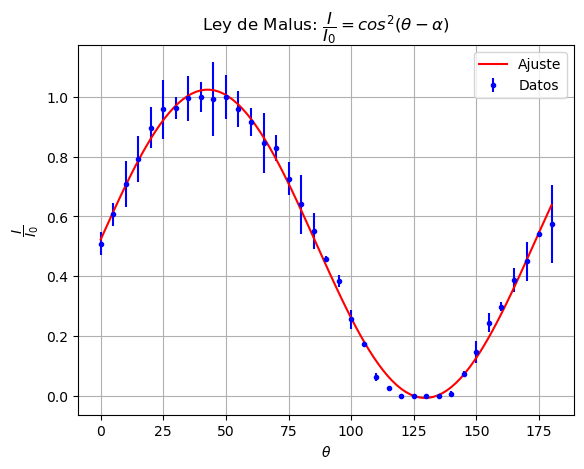

In [5]:
plt.errorbar(np.array(df.index),df['LuzProm'],yerr=5*df['ErrDom'],color='b',fmt='.',label='Datos')
xs = np.linspace(0,np.pi,100)
plt.plot(np.rad2deg(xs),func(xs,*params),'r',label='Ajuste')
plt.title(r'Ley de Malus: $\dfrac{I}{I_0}=cos^2(\theta-\alpha)$')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dfrac{I}{I_0}$')
plt.grid()
plt.legend()
plt.show()

En la gráfica, las barras de error se escalaron por un factor de 5 para que fueran visibles. La función con los parámetros que ajustan los datos es:

In [8]:
std = np.diagonal(cov)**0.5
print(f'I/I_0=({params[0]:.2f}±{std[0]:.2f})cos²(({params[1]:.3f}±{std[1]:.3f})θ-({params[2]:.2f}±{std[2]:.2f}))+({params[3]:.3f}±{std[3]:.3f})')
print(f'α=({np.rad2deg(params[2]):.1f}±{np.rad2deg(std[2]):.1f})°')

I/I_0=(1.03±0.01)cos²((1.036±0.006)θ-(0.77±0.01))+(-0.008±0.008)
α=(44.2±0.6)°


## **Conclusiones**

* Los datos se ajustan razonablemente bien a una función coseno cuadrado, verificando la ley de Malus experimentalmente.
* La luz de la pantalla utilizada está polarizada a $(44.2\pm0.6)°$.
* Con esta práctica se muestra que el ESP32, en particular, la posibilidad de controlarlo con MicroPython permite verificar una amplia variedad de fenómenos físicos.

## **Referencias**

* Eugene, H. (2000). Optica (3ª. Edicion). España. Adelphi University, 384-340.
* Born, M., & Wolf, E. (2013). Principles of optics: electromagnetic theory of propagation, interference and diffraction of light. Elsevier.
* Purcell, E. M. (2013). Electricity and magnetism. Cambridge university press.
* Haraoubia, B. (2018). Nonlinear electronics 1: nonlinear dipoles, harmonic oscillators and switching circuits. Elsevier.